# Reducing record sizes in Notification Service database

## Rationale

* Notification service database stores all Insights results for all clusters for the whole previous week
* It is different from CCX data pipeline, where just **latest** versions are stored
* So it is advisable to shrink record size by deleting data that are not required by Notification Service

## Storage demands

* CCX data pipeline: #of records in database == #of clusters
* Notification Service: # of records in database == 7 × 24 / 2 × #of clusters

## Typical record produced by OCP rules engine

* Circa 11kB of size (and it will be more with increasing number of external rules)
* Pretty printed JSON
* Contains many irrelevant parts (for Notification service)

## Irrelevant parts

* Whole `system` node
* Whole `fingerprints` node
* Whole `skips` node
* Whole `info` node"
* Whole `pass` node
* For any rule hit:
    - `type` subnode
    - `tags` subnode
    - `links`

## Further improvements

* Minification of JSON
    - no pretty printing
    - no whitespaces around separators

## Proof of concept

In [ ]:
#!/usr/bin/python
# vim: set fileencoding=utf-8

import json
import sys
import csv

from os import listdir, stat, walk
from os.path import isfile, join

input_directory = "input"
pretty_printed_directory = "prettyprinted"
minified_directory = "minified"


# Retrieve list of files in current directory.
input_files = [f for f in listdir(input_directory)
               if isfile(join(input_directory, f))]

# Iterate over all input files found in current directory.
for filename in input_files:
    print("Processing input file", filename)

    # Just proper JSON files needs to be processed.
    if filename.endswith(".json"):
        # Try to open the given file, read its content, parse it as JSON and
        # use the processed payload later
        with open(join(input_directory, filename)) as fin:
            data = json.load(fin)

            # Delete unused data
            if "Report" in data:
                del data["Report"]["system"]
                del data["Report"]["fingerprints"]
                del data["Report"]["skips"]
                del data["Report"]["info"]
                if "pass" in data["Report"]:
                    del data["Report"]["pass"]
                for report in data["Report"]["reports"]:
                    del report["type"]
                    del report["tags"]
                    del report["links"]

            # Export the updated report in pretty printed format
            outfilename = join(pretty_printed_directory, filename)
            with open(outfilename, "w") as fout:
                json.dump(data, fout, indent=4)

            # Export the updated report in minified format
            outfilename = join(minified_directory, filename)
            with open(outfilename, "w") as fout:
                json.dump(data, fout, separators=(',', ':'))

# Statistic


def file_size(filename):
    info = stat(filename)
    return info.st_size


with open("record_sizes.csv", "w") as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(["Filename", "Original", "Cleaned up", "Minified",
                     "Shrinked (%)"])

    for filename in input_files:
        s1 = file_size(join(input_directory, filename))
        s2 = file_size(join(pretty_printed_directory, filename))
        s3 = file_size(join(minified_directory, filename))
        writer.writerow([filename, s1, s2, s3, int(100.0*s3/s1)])

## Results

### Initialization part

In [63]:
# we are going to display graphs and work with data frames
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# let's display all graphs without the need to call .show()
%matplotlib inline

# set graph sizes
plt.rcParams["figure.figsize"] = (20,10)

# we are going to render our own Markdown cells
from IPython.display import Markdown as md

## Loading all data files with raw metrics
One CSV file was prepared. `record_sizes.csv` contains sizes of original record, shrinked record and minified record:

In [2]:
sizes=pd.read_csv("record_sizes.csv")

### Look into the data

In [52]:
sizes.head(20)

,Filename,Original,Cleaned up,Minified,Shrinked (%)
0,big_results.json,11072,5448,2882,26
1,big_results_tutorial.json,11505,5792,3067,26
2,result04.json,7064,679,421,5
3,no_hits.json,4407,197,151,3
4,big_results_no_skips.json,7040,5448,2882,40
5,no_hits_no_skips.json,375,197,151,40
6,big_results_org_1.json,11065,5441,2875,25
7,result01.json,7128,725,467,6
8,result05.json,7078,693,435,6
9,tutorial_only.json,2261,543,329,14


### Elementary statistic

In [7]:
# please note that some records are smaller that typical records in CCX data pipeline because we need
# to test corner cases (missing attributes etc.)
sizes.describe()

,Original,Cleaned up,Minified,Shrinked (%)
count,19.000000,19.000000,19.000000,19.000000
mean,8392.368421,3932.947368,2095.578947,22.789474
std,3420.338193,3122.321919,1610.424006,14.156188
min,375.000000,197.000000,151.000000,3.000000
25%,7065.500000,679.000000,421.000000,6.000000
50%,7473.000000,5441.000000,2875.000000,26.000000
75%,11288.500000,5792.000000,3067.000000,35.000000
max,11695.000000,8725.000000,4569.000000,41.000000


### Size comparios: original/cleaned up/minified

<AxesSubplot:title={'center':'Message sizes'}>

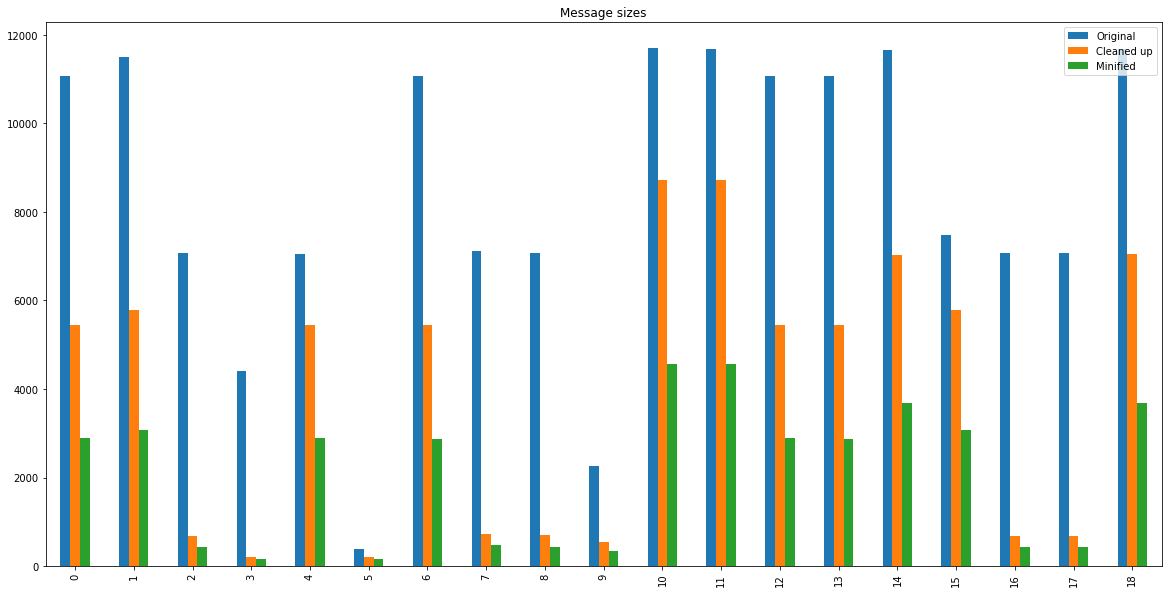

In [57]:
del sizes["Shrinked (%)"]
sizes.plot(title="Message sizes", kind="bar")

### Summary

In [58]:
d={}
for category in ('Original', 'Cleaned up', 'Minified'):
    d[category] = [sizes[category].sum()]

In [59]:
df=pd.DataFrame(d, index=["Sum"])

<AxesSubplot:>

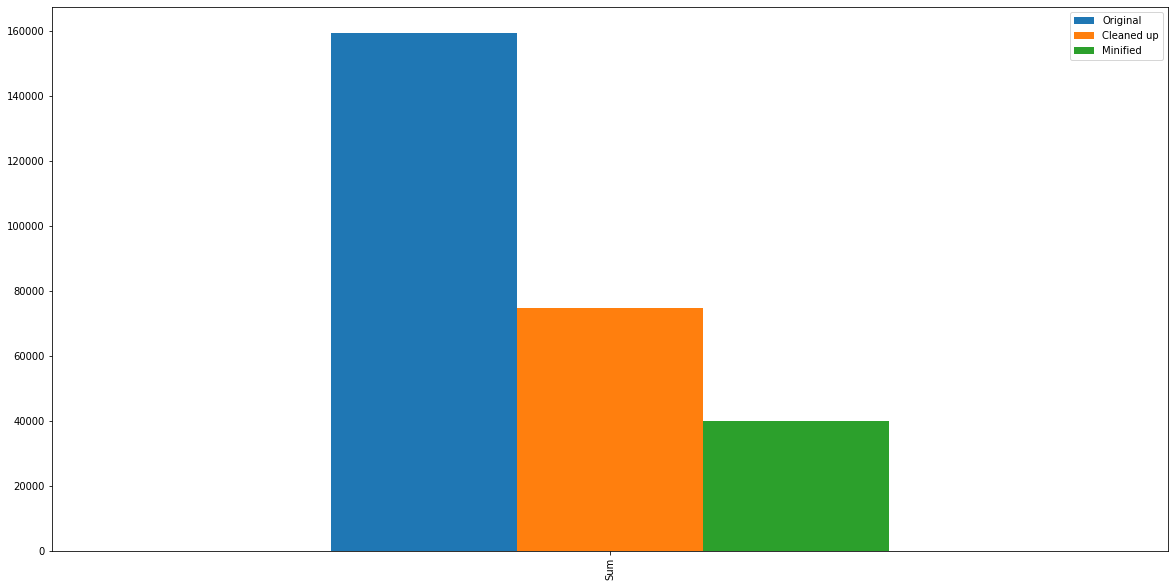

In [60]:
df.plot(kind="bar")

In [73]:
shrink = int(100.0 * d['Minified'][0]/d['Original'][0])
md("# Shrink amount: {}% from original size".format(shrink))

# Shrink amount: 24% from original size

In [76]:
x = int(7 * 24 / 2 * d['Minified'][0]/d['Original'][0])
md("# CCX pipeline database : Notification service database = 1:{}".format(x))

# CCX pipeline database : Notification service database = 1:20